In [6]:
import sys
import pandas as pd
import re
import numpy as np
import shap

sys.path.append("..")

from src.features import multitable_merge
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

%load_ext nb_black

<IPython.core.display.Javascript object>

In [7]:
data = multitable_merge("../data")

<IPython.core.display.Javascript object>

In [8]:
x = data["train"].drop(["TARGET", "SK_ID_CURR"], axis=1)
y = data["train"]["TARGET"]

print(x.shape)

(307511, 361)


<IPython.core.display.Javascript object>

In [29]:
x_test = data["test"].drop(["SK_ID_CURR"], axis=1)

for i in range(len(x.columns)):
    col_a = x.columns[i]
    
    if col_a not in x_test.columns:
        x_test[col_a] = 0


<IPython.core.display.Javascript object>

In [9]:
def stratified_kfold_train(x, y, model, fold=10, categorical_var=None):
    kf = StratifiedKFold(fold)

    models = []
    scores = []
    cls_reports = []

    for train_idx, test_idx in kf.split(x, y):
        x_train, y_train = x.iloc[train_idx], y.iloc[train_idx]
        x_test, y_test = x.iloc[test_idx], y.iloc[test_idx]

        model.fit(x_train, y_train)

        proba = model.predict_proba(x_test)
        pred = proba.argmax(1)

        roc = roc_auc_score(y_test, proba[:, 1])
        report = classification_report(y_test, pred, digits=4)
        print(roc)
        print(report)

        models.append(model)
        scores.append(roc)
        cls_reports.append(
            classification_report(
                y_test,
                pred,
                digits=4,
                output_dict=True,
            )
        )

    # train final model
    model.fit(x, y)

    return {
        "model": model,
        "kfold_models": models,
        "roc_scores": scores,
        "classification_reports": cls_reports,
    }

<IPython.core.display.Javascript object>

In [35]:
def tree_like_featture_importance(model, x_test, y_test):
    return model.feature_importances_


def permutation_feature_importances(model, x_test, y_test):
    r = permutation_importance(
        model, x_test, y_test, n_repeats=30, random_state=0, n_jobs=8
    )
    return r.importances_mean


def shap_feature_importances(model, x_test, y_test, tree=False):
    if tree:
        explainer = shap.TreeExplainer(model, x_test)
    else:
        proba = model.predict_proba(x_test)
        explainer = shap.KernelExplainer(proba, x_test)
    shap_val = explainer.shap_values(x_test, check_additivity=False)
    return shap_val

<IPython.core.display.Javascript object>

In [97]:
knn = KNeighborsClassifier(5, n_jobs=4)
rf = RandomForestClassifier(n_estimators=500, n_jobs=4, class_weight="balanced")
lgbm = LGBMClassifier(
    n_estimators=500, n_jobs=4, scale_pos_weight=(len(y) - y.sum()) / y.sum()
)
xgb = XGBClassifier(
    n_estimators=500, n_jobs=4, scale_pos_weight=(len(y) - y.sum()) / y.sum()
)

<IPython.core.display.Javascript object>

In [98]:
r_knn = stratified_kfold_train(x.fillna(-1), y, knn, 5)

0.5455246312428537
              precision    recall  f1-score   support

           0     0.9200    0.9933    0.9552     56538
           1     0.1751    0.0161    0.0295      4965

    accuracy                         0.9144     61503
   macro avg     0.5475    0.5047    0.4924     61503
weighted avg     0.8598    0.9144    0.8805     61503

0.5458414073889104
              precision    recall  f1-score   support

           0     0.9199    0.9931    0.9551     56537
           1     0.1674    0.0157    0.0287      4965

    accuracy                         0.9142     61502
   macro avg     0.5437    0.5044    0.4919     61502
weighted avg     0.8592    0.9142    0.8803     61502

0.5471224407027269
              precision    recall  f1-score   support

           0     0.9197    0.9920    0.9545     56537
           1     0.1344    0.0141    0.0255      4965

    accuracy                         0.9131     61502
   macro avg     0.5270    0.5031    0.4900     61502
weighted avg     

<IPython.core.display.Javascript object>

In [15]:
r_rf = stratified_kfold_train(x.fillna(-1), y, rf, 5)

0.7532937057688156
              precision    recall  f1-score   support

           0     0.9194    0.9999    0.9580     56538
           1     0.6000    0.0018    0.0036      4965

    accuracy                         0.9193     61503
   macro avg     0.7597    0.5009    0.4808     61503
weighted avg     0.8936    0.9193    0.8809     61503

0.756340756699696
              precision    recall  f1-score   support

           0     0.9193    0.9998    0.9579     56537
           1     0.3750    0.0012    0.0024      4965

    accuracy                         0.9192     61502
   macro avg     0.6472    0.5005    0.4802     61502
weighted avg     0.8754    0.9192    0.8808     61502

0.7498858049824727
              precision    recall  f1-score   support

           0     0.9194    0.9999    0.9580     56537
           1     0.6667    0.0016    0.0032      4965

    accuracy                         0.9193     61502
   macro avg     0.7930    0.5008    0.4806     61502
weighted avg     0

<IPython.core.display.Javascript object>

In [16]:
r_xgb = stratified_kfold_train(x.fillna(-1), y, xgb, 5)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[18:05:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.7340885740314502
              precision    recall  f1-score   support

           0     0.9455    0.8707    0.9066     56538
           1     0.2256    0.4290    0.2957      4965

    accuracy                         0.8350     61503
   macro avg     0.5856    0.6499    0.6012     61503
weighted avg     0.8874    0.8350    0.8573     61503



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[18:14:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.7385301635922157
              precision    recall  f1-score   support

           0     0.9454    0.8710    0.9067     56537
           1     0.2251    0.4268    0.2948      4965

    accuracy                         0.8351     61502
   macro avg     0.5852    0.6489    0.6007     61502
weighted avg     0.8872    0.8351    0.8573     61502



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[18:22:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.7305857684905825
              precision    recall  f1-score   support

           0     0.9443    0.8701    0.9057     56537
           1     0.2192    0.4151    0.2869      4965

    accuracy                         0.8334     61502
   macro avg     0.5817    0.6426    0.5963     61502
weighted avg     0.8857    0.8334    0.8557     61502



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[18:30:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.7347878273656259
              precision    recall  f1-score   support

           0     0.9456    0.8712    0.9069     56537
           1     0.2266    0.4296    0.2967      4965

    accuracy                         0.8356     61502
   macro avg     0.5861    0.6504    0.6018     61502
weighted avg     0.8876    0.8356    0.8576     61502



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[18:38:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.7386119822324555
              precision    recall  f1-score   support

           0     0.9453    0.8700    0.9061     56537
           1     0.2239    0.4272    0.2938      4965

    accuracy                         0.8342     61502
   macro avg     0.5846    0.6486    0.6000     61502
weighted avg     0.8871    0.8342    0.8567     61502



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[18:47:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<IPython.core.display.Javascript object>

In [17]:
r_lgbm = stratified_kfold_train(
    x.fillna(-1).rename(columns=lambda x: re.sub("[^A-Za-z0-9_]+", "", x)),
    y,
    lgbm,
    5,
)

0.7717170926970951
              precision    recall  f1-score   support

           0     0.9585    0.7834    0.8621     56538
           1     0.1992    0.6135    0.3007      4965

    accuracy                         0.7697     61503
   macro avg     0.5788    0.6984    0.5814     61503
weighted avg     0.8972    0.7697    0.8168     61503

0.7755612420466445
              precision    recall  f1-score   support

           0     0.9593    0.7832    0.8623     56537
           1     0.2011    0.6213    0.3038      4965

    accuracy                         0.7701     61502
   macro avg     0.5802    0.7023    0.5831     61502
weighted avg     0.8981    0.7701    0.8173     61502

0.7689690507553975
              precision    recall  f1-score   support

           0     0.9576    0.7846    0.8625     56537
           1     0.1978    0.6048    0.2981      4965

    accuracy                         0.7701     61502
   macro avg     0.5777    0.6947    0.5803     61502
weighted avg     

<IPython.core.display.Javascript object>

In [85]:
scores = []
for name, r in [
    ("knn", r_knn),
    ("random forest", r_rf),
    ("lgbm", r_lgbm),
    ("xgb", r_xgb),
]:
    for i in range(len(r["roc_scores"])):
        scores.append(
            {
                "model": name,
                "fold": i + 1,
                "roc": r["roc_scores"][i],
                "f1-score": r["classification_reports"][i]["1"]["f1-score"],
                "precision": r["classification_reports"][i]["1"]["precision"],
                "recall": r["classification_reports"][i]["1"]["recall"],
            }
        )
scores = pd.DataFrame(scores)

<IPython.core.display.Javascript object>

In [86]:
scores

,model,fold,roc,f1-score,precision,recall
0,knn,1,0.586897,0.000000,0.000000,0.000000
1,knn,2,0.595229,0.000000,0.000000,0.000000
2,knn,3,0.585586,0.000000,0.000000,0.000000
3,knn,4,0.591523,0.000000,0.000000,0.000000
4,knn,5,0.583988,0.000000,0.000000,0.000000
5,random forest,1,0.753294,0.003614,0.600000,0.001813
6,random forest,2,0.756341,0.002409,0.375000,0.001208
7,random forest,3,0.749886,0.003215,0.666667,0.001611
8,random forest,4,0.756487,0.001610,0.800000,0.000806
9,random forest,5,0.758557,0.002413,0.666667,0.001208


<IPython.core.display.Javascript object>

In [96]:
np.round(
    scores.groupby(["model"]).agg(
        {
            "roc": ["mean"],
            "f1-score": ["mean"],
            "precision": ["mean"],
            "recall": ["mean"],
        }
    ),
    3,
)

,roc,f1-score,precision,recall
,mean,mean,mean,mean
model,,,,
knn,0.589,0.000,0.000,0.000
lgbm,0.773,0.301,0.200,0.610
random forest,0.755,0.003,0.622,0.001
xgb,0.735,0.294,0.224,0.426


<IPython.core.display.Javascript object>

In [36]:
shap_val_lgbm = shap_feature_importances(r_lgbm["model"], x_test, None, True)

100%|===================| 48729/48744 [08:30<00:00]        

<IPython.core.display.Javascript object>

In [39]:
shap_val_lgbm.shape

(48744, 361)

<IPython.core.display.Javascript object>

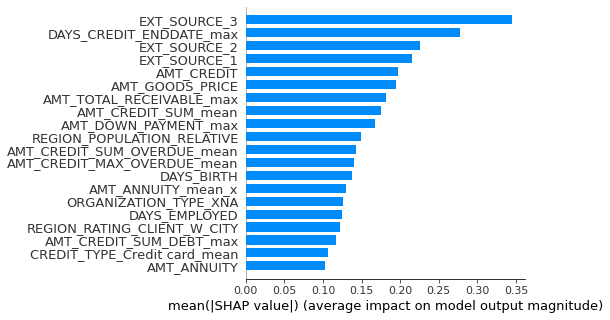

<IPython.core.display.Javascript object>

In [83]:
shap.summary_plot(shap_val_lgbm, x_test, plot_type="bar", plot_size=(5, 5))

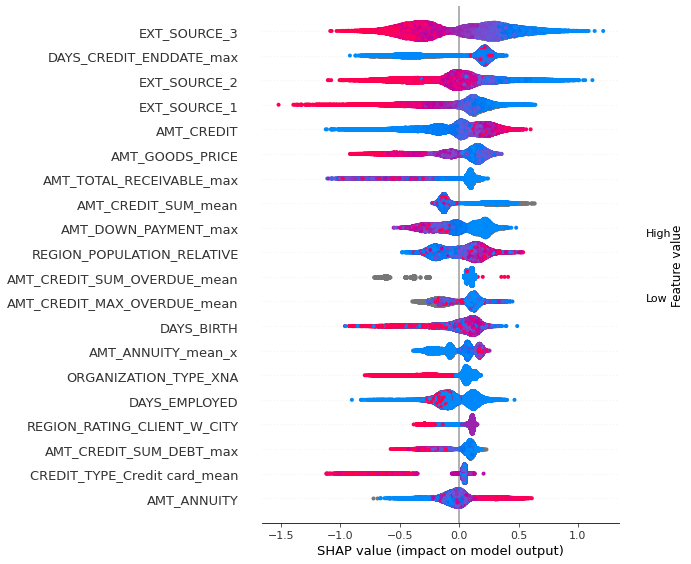

<IPython.core.display.Javascript object>

In [162]:
shap.summary_plot(
    shap_val_lgbm,
    x_test,
)

### Save models

In [163]:
import joblib

<IPython.core.display.Javascript object>

In [165]:
scores = []
for name, r in [
    ("knn", r_knn),
    ("random forest", r_rf),
    ("lgbm", r_lgbm),
    ("xgb", r_xgb),
]:
    with open("../models/{}.pkl".format(name), "wb") as f:
        joblib.dump(r, f)

<IPython.core.display.Javascript object>